Discourse-semantics of *risk* in the *New York Times*, 1963&ndash;2014
==========================================

**[Jens Zinn](mailto:jzinn@unimelb.edu.au?Subject=IPython%20NYT%20risk%20project), [Daniel McDonald](mailto:mcdonaldd@unimelb.edu.au?Subject=IPython%20NYT%20risk%20project)**
--------------------------

<br>

> **SUMMARY:** This *IPython Notebook* demonstrates the findings from our investigation of *risk* in the NYT, as well as the code used to generate these findings. If you have the necessary dependencies installed, you can also use this notebook to interrogate and visualise the corpus yourself. 

### Setup

If you haven't already done so, the first things we need to do are **install corpkit**, download data for NLTK's tokeniser, and **unzip our corpus**.

In [ ]:
# install corpkit with either pip or easy_install
try:
    import pip
    pip.main(['install', 'corpkit'])
except ImportError:
    import easy_install
    easy_install.main(["-U","corpkit"])

In [ ]:
# download nltk tokeniser data
import nltk
nltk.download('punkt')

In [ ]:
# unzip and untar our data
! gzip -dc data/bipolar.tar.gz | tar -xf - -C data

Great! Now we have everything we need to start.

### Orientation

 Let's import the functions we'll be using to investigate the corpus. These functions are designed for this interrogation, but also have more general use in mind, so you can likely use them on your own corpora.

| **Function name** | Purpose                            | |
| ----------------- | ---------------------------------- | |
| `interrogator()`  | interrogate parsed corpora         | |
| `dependencies()`  | interrogate parsed corpora for dependency info (presented later)  | |
| `plotter()`       | visualise `interrogator()` results | |
| `table()`          | return plotter() results as table | |
| `quickview()`     | view `interrogator()` results      | |
| `tally()`       | get total frequencies for `interrogator()` results      | |
| `surgeon()`       | edit `interrogator()` results      | |
| `merger()`       | merge `interrogator()` results      | |
| `conc()`          | complex concordancing of subcorpora | |
| `keywords()`          | get keywords and ngrams from `conc()` output | |
| `collocates()`          | get collocates from `conc()` output| |
| `quicktree()`          | visually represent a parse tree | |
| `searchtree()`          | search a parse tree with a Tregex query | |

In [1]:
import os # for joining paths
import corpkit
from corpkit import (
    interrogator, plotter, table, quickview, 
    tally, surgeon, merger, conc, keywords, 
    collocates, multiquery, report_display 
                    )
# show figures in browser
% matplotlib inline

Next, let's set the path to our corpus. If you were using this interface for your own corpora, you would change this to the path to your data.

In [2]:
# corpus of every article, with annual subcorpora
annual_trees = 'data/nyt/years' 

### The report

The focus of this notebook is our methodology and findings. These parts of the project are contextualised and elaborated upon in our written report of the project. Depending on your browser's capabilities/settings, the following will download or display our report:

In [4]:
report_display()

### The data

Our main corpus is comprised of paragraphs from *New York Times* articles that contain a risk word, which we have defined by regular expression as '(?i)'.?\brisk.?\b'. This includes *low-risk*, or *risk/reward* as single tokens, but excludes *brisk* or *asterisk*.

The data comes from a number of sources.

* 1963 editions were downloaded from ProQuest Newsstand as PDFs. Optical character recognition and manual processing was used to create a set of 1200 risk sentences.
* The 1987&ndash;2006 editions were taken from the *NYT Annotated Corpus*.
* 2007&ndash;2014 editions were downloaded from *ProQuest Newsstand* as HTML.

In total, 149,504 documents were processed. The corpus from which the risk corpus was made is over 150 million words in length!

The texts have been parsed for part of speech and grammatical structure by [`Stanford CoreNLP*](http://nlp.stanford.edu/software/corenlp.shtml). In this Notebook, we are only working with the parsed versions of the texts. We rely on [*Tregex*](http://nlp.stanford.edu/~manning/courses/ling289/Tregex.html) to interrogate the corpora. Tregex allows very complex searching of parsed trees, in combination with [Java Regular Expressions](http://docs.oracle.com/javase/7/docs/api/java/util/regex/Pattern.html). It's definitely worthwhile to learn the Tregex syntax, but in case you're time-poor, at the end of this notebook are a series of Tregex queries that you can copy and paste into *interrogator()` and `conc()` queries.

### Interrogating the corpus

So, let's start by generating some general information about this corpus. First, let's define a query to find every word in the corpus. Run the cell below to define the *allwords_query* variable as the Tregex query to its right.

> *When writing Tregex queries or Regular Expressions, remember to always use **r'...'** quotes!*

In [5]:
# any token containing letters or numbers (i.e. no punctuation):
allwords_query = r'/[A-Za-z0-9]/ !< __' 

Next, we perform interrogations with `interrogator()`. Its most important arguments are:

1. **path to corpus**

2. Tregex **options**:
  * **'-t'**: return only words
  * **'-C'**: return a count of matches
  * **'-u'**: return only the tag
  * **'-o'**: return tag and word together

3. the **Tregex query**

We only need to count tokens, so we can use the **-C** option (it's often faster than getting lists of matching tokens). The cell below will run interrogator() over each annual subcorpus and count the number of matches for the query.

In [ ]:
allwords = interrogator(annual_trees, '-C', allwords_query) 


18:39:57: Beginning corpus interrogation: data/nyt/years
          Query: '/[A-Za-z0-9]/ !< __'
          Counts only.
          Interrogating corpus ... 

18:41:07: [**********                17%                             ] 

When the interrogation has finished, we can view our results:

In [14]:
# from the allwords results, print the totals
print allwords.totals

[u'Totals', [1963, 83325], [1987, 481830], [1988, 450872], [1989, 473741], [1990, 443712], [1991, 397694], [1992, 402754], [1993, 412920], [1994, 458677], [1995, 475672], [1996, 413403], [1997, 402636], [1998, 468697], [1999, 467253], [2000, 481373], [2001, 494127], [2002, 556852], [2003, 543076], [2004, 550630], [2005, 547293], [2006, 524091], [2007, 453255], [2008, 496002], [2009, 472376], [2010, 505927], [2011, 545237], [2012, 497773], [2013, 489154], [2014, 311634], [u'Total', 13301986]]


If you want to see the query and options that created the results, you can use:

In [8]:
print allwords.query

['data/nyt/years', '/[A-Za-z0-9]/ !< __', '-C']


### Plotting results

Lists of years and totals are pretty dry. Luckily, we can use the `plotter()` function to visualise our results. At minimum, `plotter()` needs two arguments:

1. a title (in quotation marks)
2. a list of results to plot

There is also an argument for projecting the 1963 and 2014 results, which can either be set to true or false. By default, it is true, and in this Notebook from now on we'll leave it turned on. We'll try both options here:

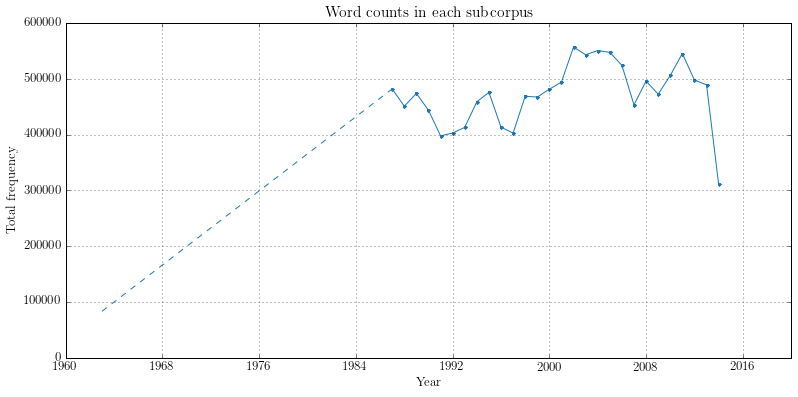

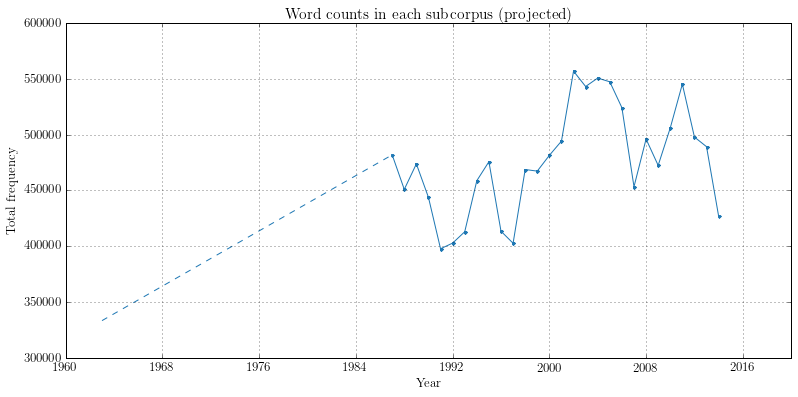

In [17]:
plotter('Word counts in each subcorpus', allwords.totals, projection = False)
plotter('Word counts in each subcorpus (projected)', allwords.totals, projection = True)

Great! So, we can see that the number of words per year varies quite a lot. That's worth keeping in mind.

### Frequency of risk words in the NYT

Next, let's count the total number of risk words. Notice that we are using the '-o' flag, instead of the **-C** flag.

In [10]:
# our query:
riskwords_query = r'__ < /(?i).?\brisk.?\b/' # any risk word and its word class/part of speech
# get all risk words and their tags:
riskwords = interrogator(annual_trees, '-o', riskwords_query)

Even when do not use the -C flag, we can access the total number of matches as before:

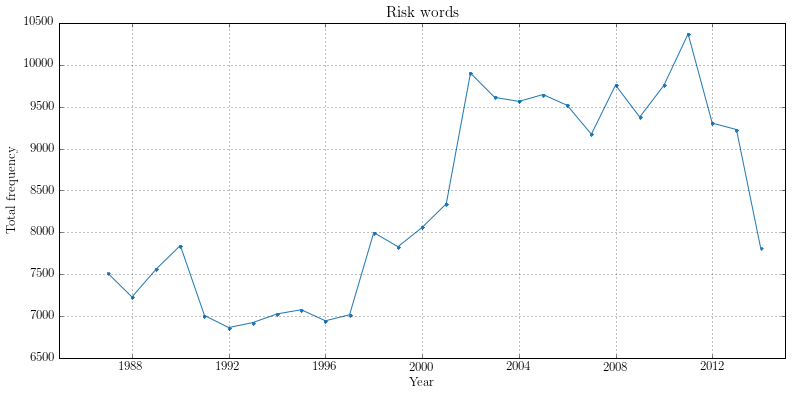

In [11]:
plotter('Risk words', riskwords.totals)

At the moment, it's hard to tell whether or not these counts are simply because our annual NYT samples are different sizes. To account for this, we can calculate the percentage of parsed words that are risk words. This means combining the two interrogations we have already performed.

We can do this by passing a third argument to `plotter()`.

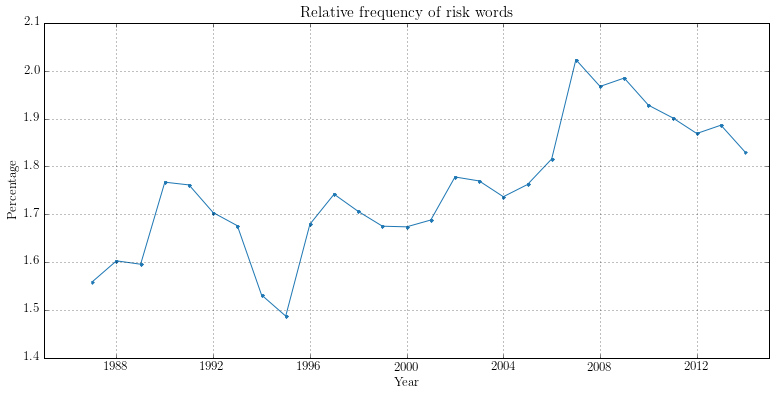

In [12]:
plotter('Relative frequency of risk words', riskwords.totals, 
    fract_of = allwords.totals)

That's more helpful. We can now see some interesting peaks and troughs in the proportion of risk words. We can also see that 1963 contains the highest proportion of risk words. This is because the manual corrector of 1963 OCR entries preserved only the sentence containing risk words, rather than the paragraph.

It's often helpful to not plot 1963 results for this reason. To do this, we can add an argument to the `plotter()` call:

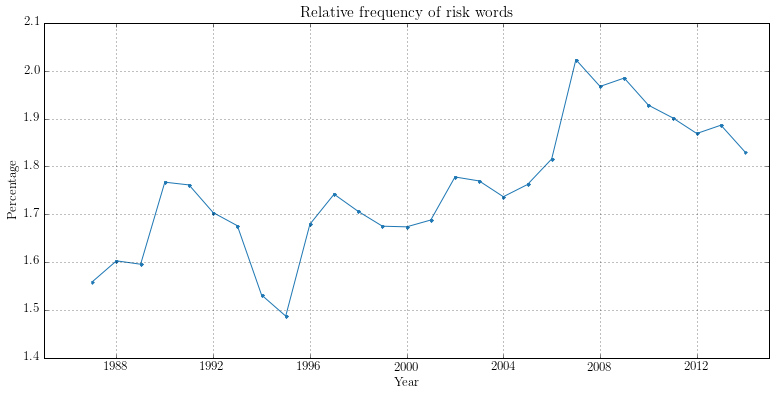

In [13]:
plotter('Relative frequency of risk words', riskwords.totals, 
    fract_of = allwords.totals, skip63 = True)

Perhaps we're interested in not only the frequency of risk words, but the frequency of different `kinds* of risk words. We actually already collected this data during our last *interrogator()` query.

We can print just the first three entries of the results list, rather than the totals list:

In [18]:
for word in riskwords.results[:3]:
    print word
# uncomment below to print the totals:
# print riskwords.totals

[u'( nn risk )', [1963, 740], [1987, 4116], [1988, 4049], [1989, 4164], [1990, 4223], [1991, 3825], [1992, 3578], [1993, 3822], [1994, 3837], [1995, 3905], [1996, 3882], [1997, 3955], [1998, 4381], [1999, 4263], [2000, 4407], [2001, 4706], [2002, 5722], [2003, 5605], [2004, 5625], [2005, 5538], [2006, 5415], [2007, 5505], [2008, 5877], [2009, 5409], [2010, 5596], [2011, 6107], [2012, 5376], [2013, 5476], [2014, 3395], [u'Total', 132499]]
[u'( nns risks )', [1963, 404], [1987, 1612], [1988, 1453], [1989, 1534], [1990, 1508], [1991, 1372], [1992, 1533], [1993, 1426], [1994, 1507], [1995, 1429], [1996, 1335], [1997, 1389], [1998, 1607], [1999, 1646], [2000, 1657], [2001, 1670], [2002, 2199], [2003, 1926], [2004, 1930], [2005, 2045], [2006, 2022], [2007, 2028], [2008, 2063], [2009, 2096], [2010, 2218], [2011, 2354], [2012, 2102], [2013, 2019], [2014, 1307], [u'Total', 49391]]
[u'( jj risky )', [1963, 65], [1987, 549], [1988, 511], [1989, 543], [1990, 612], [1991, 530], [1992, 545], [1993, 

We now have enough data to do some serious plotting.

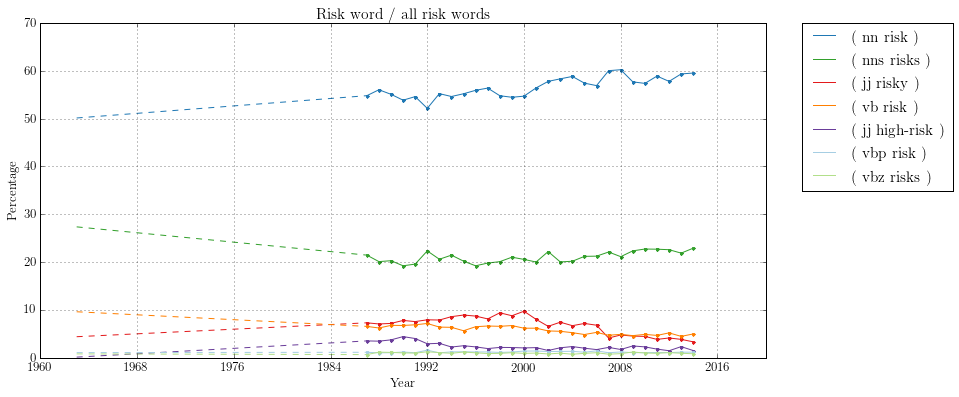

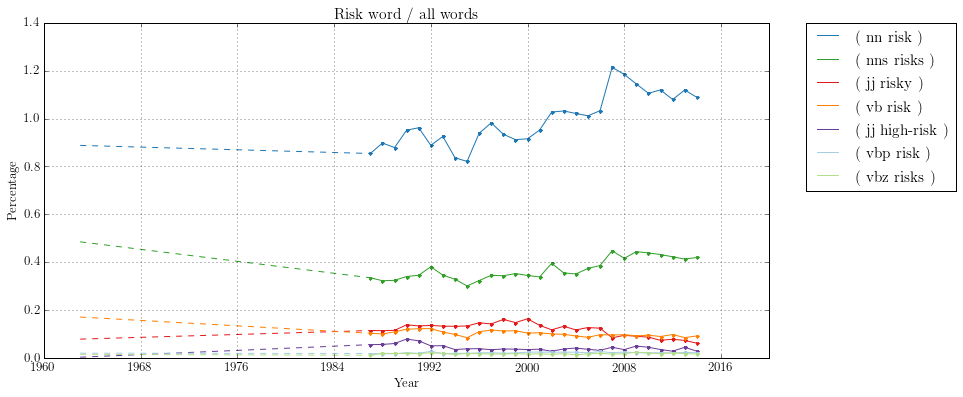

In [19]:
plotter('Risk word / all risk words', riskwords.results, 
    fract_of = riskwords.totals)
plotter('Risk word / all words', riskwords.results, 
    fract_of = allwords.totals)

### Customising visualisations

By default, `plotter()` plots the seven most frequent results, including 1963 and projecting 1963 and 2014.

 We can use other `plotter()` arguments to customise what our chart shows. `plotter()`'s possible arguments are:

 | plotter() argument | Mandatory/default?       |  Use          | Type  |
 | :------|:------- |:-------------|:-----|
 | *title* | **mandatory**      | A title for your plot | string |
 | `results* | **mandatory**      | the results you want to plot | *interrogator()` total |
 | *fract_of* | None      | results for plotting relative frequencies/ratios etc. | list (interrogator(-C) form) |
 | *num_to_plot* | 7     | number of top results to display     |   integer |
 | *skip63* | False    | do not plot 1963     |    integer |
 | *proj63* | 4     | multiplier to project 1963 results and totals | integer |
 | *multiplier* | 100     | result * multiplier / total: use 1 for ratios | integer |
 | *x_label* | False    | custom label for the x-axis     |  string |
 | *y_label* | False    | custom label for the y-axis     |  string |
 | *legend_totals* | False    | Print total/rel freq in legend     |  boolean 
 | *projection* | True    | Project 1963 and 2014 editions     |  boolean |
 | *yearspan* | False    | plot a span of years |  a list of two int years |
 | *csvmake* | False    | make csvmake the title of csv output file    |  string |
 | *save* | False    | save generated image (True = with title as name)   |  True/False/string |

You can easily use these to get different kinds of output. Try changing some parameters below:

In [ ]:
plotter('Relative frequencies of risk words', riskwords.results, fract_of = allwords.totals,
    y_label = 'Percentage of all risk words', num_to_plot = 5, 
    skip63 = False, projection = True, proj63 = 5, csvmake = 'riskwords.csv', legend_totals = True)

If you just generated a csv file, you can quickly get the results with:

In [ ]:
!cat 'riskwords.csv'  | head -n 7
# and to delete it:
#!rm 'riskwords.csv'

Use *yearspan* to specify years of interest:

In [ ]:
plotter('Relative frequencies of risk words', riskwords.results, fract_of = allwords.totals,
    y_label = 'Percentage of all risk words', num_to_plot = 5, skip63 = False, 
    yearspan = [1963,1998])

Another way to change `plotter()` visualisations is by not passing certain results to `plotter()`.

Each entry in the list of results is indexed: the top result is item 0, the second result is item 1, and so on.

So, you can skip the first 2 results by using [2:] after the results list:

In [ ]:
plotter('Relative frequencies of risk words', riskwords.results[2:], fract_of = allwords.totals,
    y_label = 'Percentage of all risk words', num_to_plot = 5, skip63 = False, projection = True, proj63 = 5, legend_totals = True)

If you are after a specific set of indexed items, it's probably better to use `surgeon()` (described below). For completeness, though, here's another way:

In [ ]:
indices_we_want = [32,30,40]
plotter('Relative frequencies of risk words', [ riskwords.results[i] for i in indices_we_want], 
        num_to_plot = 5, skip63 = True, projection = True, proj63 = 5)

### table()

If you want to quickly table the results of a csv file, you can use `table()`. Its only main argument is the path to the csv file as string. There are two optional arguments. First, you can set *allresults* to *True* to table all results, rather than just the plotted results. When this option is set to true, you may get *way* too many results. To cope with this, there is a *maxresults* argument, whose value by default is 50. You can overwrite this default to table more or fewer results.

In [ ]:
table('riskwords.csv')

In [ ]:
table('riskwords.csv', allresults = True, maxresults = 30)

### quickview()

`quickview()` is a function that quickly shows the n most frequent items in a list. Its arguments are:

1. an `interrogator()` result
2. number of results to show (default = 50)

In [ ]:
quickview(riskwords.results, n = 25)

The number shown next to the item is its index. You can use this number to refer to an entry when editing results.

### tally()

`tally()` simply displays the total occurrences of results. Its first argument is the list you want tallies from. For its second argument, you can use:

* a list of indices for results you want to tally
* a single integer, which will be interpreted as the index of the item you want
* a regular expression to search for
* a string, 'all', which will tally every result. This could be very many results, so it may be worth limiting the number of items you pass to it with [:n], as in the second example below:

In [ ]:
tally(riskwords.results, [0, 5, 10])

In [ ]:
tally(riskwords.results[:10], 'all')

The Regular Expression option is useful for merging results (see below).

### surgeon()

Results lists can be edited quickly with `surgeon()`. `surgeon()`'s arguments are:

1. an `interrogator()` results list
2. *criteria*: either a [Regular Expression](http://www.cheatography.com/davechild/cheat-sheets/regular-expressions/) or a list of indices.
3. *remove = True/False*

By default, `surgeon()` keeps anything matching the regex, but this can be inverted with a *remove = True* argument. Because you are duplicating the original list, you don't have to worry about deleting `interrogator()` results.

In [ ]:
# low and high risks, using indices 
lowhighrisks = surgeon(riskwords.results, [4, 9, 17]) # keep 4, 9 and 17
plotter('Low-, high- and higher- risk', lowhighrisks.results, num_to_plot = 3, skip63 = True)

# only hyphenate words:
nohyphenates = surgeon(riskwords.results, r'\b.*-.*\b', remove = True) # remove tokens with hyphens
quickview(nohyphenates.results)
plotter('Non-hypenate risk words', nohyphenates.results, fract_of = riskwords.totals, 
    y_label = 'Percentage of all risk words', num_to_plot = 7, skip63 = True)

# only verbal risk words
verbalrisks = surgeon(riskwords.results, r'^\(v.*') #keep any token with tag starting with 'v'
plotter('Verbal risk words', verbalrisks, fract_of = allwords.totals, 
    y_label = 'Percentage of all words', num_to_plot = 6, skip63 = True)

Note the warning you'll receive if you specify an interrogation, rather than a results list.

### merger()

`merger()` is for merging items in a list. Like `surgeon()`, it duplicates the old list. Its arguments are:

1. the list you want to modify
2. the indices of results you want to merge, or a regex to match
3. newname = *str/int/False*: 
  * if string, the string becomes the merged item name.
  * if integer, the merged entry takes the name of the item indexed with the integer.
  * if not specified/False, the most most frequent item in the list becomes the name.

In [ ]:
low_high_combined = merger(lowhighrisks.results, [0, 2],  newname = 'high/higher risk')
plotter('Low and high risks', low_high_combined.results)

### Diversity of risk words

It's important to note that the kind of results we generate are hackable. Using some straight Python, combined with `merger()`, we can figure out how unique risk words appear in the NYT each year.

To do this, we can take `riskwords.results`, duplicate it, and change every count over 0 into 1.

In [ ]:
import copy
all_ones = copy.deepcopy(riskwords.results)
for entry in all_ones:
    for tup in entry[1:]:
        if tup[1] > 0:
            tup[1] = 1

We can then use `merger()` to merge every entry. This will tell use how many unique words there are each year.

In [ ]:
# this generates heaps of output, so let's clear it
mergedresults = merger(all_ones.results, r'.*', newname = 'Different risk words')
clear_output()

In [ ]:
# you could also use mergedresults.results[0]
plotter('Diversity of risk words', mergedresults.totals, 
    skip63 = True, y_label = 'Unique risk words')

So, we can see a generally upward trajectory, with more risk words constantly being used. Many of these results appear once, however, and many are nonwords. *Can you figure out how to remove words that appear only once per year?*

### conc()

`conc()` produces concordances of a subcorpus based on a Tregex query. Its main arguments are:

1. A subcorpus to search *(remember to put it in quotation marks!)*
2. A Tregex query

In [ ]:
# here, we use a subcorpus of politics articles,
# rather than the total annual editions.
lines = conc('data/nyt/politics/1999', r'/JJ.?/ << /(?i).?\brisk.?\b/') # adj containing a risk word

You can set `conc()` to print only the first ten examples with `n = 10`, or ten random these with the `n = 15, random = True` parameter.

In [ ]:
lines = conc('data/nyt/years/2007', r'/VB.?/ < /(?i).?\brisk.?\b/', n = 15, random = True)

`conc()` takes another argument, window, which alters the amount of co-text appearing either side of the match. The default is 50 characters

In [ ]:
lines = conc('data/nyt/health/2013', r'/VB.?/ << /(?i).?\brisk.?\b/', n = 15, random = True, window = 20)

`conc()` also allows you to view parse trees. By default, it's false:

In [ ]:
lines = conc('data/nyt/years/2013', r'/VB.?/ < /(?i)\btrad.?/', trees = True)

The final `conc()` argument is a *csv = 'filename'*, which will produce a tab-separated spreadsheet with the results of your query. You can copy and paste this data into Excel.

In [ ]:
lines = conc('data/nyt/years/2005', r'/JJ.?/ < /(?i).?\brisk.?/ > (NP <<# /(?i)invest.?/)',
    window = 30, trees = False, csvmake = 'concordances.csv')

In [ ]:
!cat 'concordances.csv'
# and to delete it:
# !rm 'concordances.txt'

### Keywords, ngrams and collocates

There are also functions for keywording, ngramming and collocation. Each can take a number of kinds of input data:

1. a path to a subcorpus (of either parse trees or raw text)
2. a path to a csv file generated with `conc()`
3. a string of text
4. a list of strings (i.e. output from `conc()`) 

 `keywords()` produces both keywords and ngrams. It relies on code from the [Spindle](http://openspires.oucs.ox.ac.uk/spindle/) project.

In [ ]:
keys, ngrams = keywords('concordances.csv')
for key in keys[:10]:
    print key
for ngram in ngrams:
    print ngram

In [ ]:
colls = collocates('concordances.csv')
for coll in colls:
    print coll

With the `collocates()` function, you can specify the maximum distance at which two tokens will be considered collocates.

In [ ]:
colls = collocates('concordances.csv', window = 2)
for coll in colls:
    print coll

### quicktree() and searchtree()

The two functions are useful for visualising and searching individual syntax trees. They have proven useful as a way to practice your Tregex queries.

The easiest place to get a parse tree is from a CSV file generated using `conc()` with *trees* set to *True*. Alternatively, you can open files in the data directory directly.

`quicktree()` generates a visual representation of a parse tree. Here's one from 1989:

In [ ]:
tree = '(ROOT (S (NP (NN Pre-conviction) (NN attachment)) (VP (VBZ carries) (PP (IN with) (NP (PRP it))) (NP (NP (DT the) (JJ obvious) (NN risk)) (PP (IN of) (S (VP (VBG imposing) (NP (JJ drastic) (NN punishment)) (PP (IN before) (NP (NN conviction)))))))) (. .)))'
quicktree(tree)

`searchtree()` requires a tree and a Tregex query. It will return a list of query matches.

In [ ]:
print searchtree(tree, r'/VB.?/ >># (VP $ NP)')
print searchtree(tree, r'NP')

Now you're familiar with the corpus and functions. Before we start our corpus interrogation, we'll also present a *very* brief explanation of *Systemic Functional Linguistics*&mdash;the theory of language that underlies our analytical approach.

### Functional linguistics

*Functional linguistics* is a research area concerned with how *realised language* (lexis and grammar) work to achieve meaningful social functions. One functional linguistic theory is *Systemic Functional Linguistics*, developed by Michael Halliday.

In [ ]:
from IPython.display import HTML
HTML('<iframe src=http://en.mobile.wikipedia.org/wiki/Michael_Halliday?useformat=mobile width=700 height=350></iframe>')

Central to the theory is a division between **experiential meanings** and **interpersonal meanings**.

* Experiential meanings communicate what happened to whom, under what circumstances.
* Interpersonal meanings negotiate identities and role relationships between speakers 

Halliday argues that these two kinds of meaning are realised **simultaneously** through different parts of English grammar.

* Experiential meanings are made through **transitivity choices**.
* Interpersonal meanings are made through **mood choices**

Here's one visualisation of it. We're concerned with the two left-hand columns. Each level is an abstraction of the one below it.

<br>
<img style="float:left" src="https://raw.githubusercontent.com/interrogator/sfl_corpling/master/cmc-2014/images/egginsfixed.jpg" alt="SFL metafunctions"  height="500" width="500" />
<br>

Transitivity choices include fitting together configurations of:

* Participants (*a man, green bikes*)
* Processes (*sleep, has always been, is considering*)
* Circumstances (*on the weekend*, *in Australia*)

Mood features of a language include:

* Mood types (*declarative, interrogative, imperative*)
* Modality (*would, can, might*)
* Lexical density&mdash;the number of words per clause, the number of content to non-content words, etc.

Lexical density is usually a good indicator of the general tone of texts. The language of academia, for example, often has a huge number of nouns to verbs. We can approximate an academic tone simply by making nominally dense clauses: 

      The consideration of interest is the potential for a participant of a certain demographic to be in Group A or Group B*.

Notice how not only are there many nouns (*consideration*, *interest*, *potential*, etc.), but that the verbs are very simple (*is*, *to be*).

In comparison, informal speech is characterised by smaller clauses, and thus more verbs.

      A: Did you feel like dropping by?
      B: I thought I did, but now I don't think I want to

Here, we have only a few, simple nouns (*you*, *I*), with more expressive verbs (*feel*, *dropping by*, *think*, *want*)

> **Note**: SFL argues that through *grammatical metaphor*, one linguistic feature can stand in for another. *Would you please shut the door?* is an interrogative, but it functions as a command. *invitation* is a nominalisation of a process, *invite*. We don't have time to deal with these kinds of realisations, unfortunately.

### Functional roles of *risk* in the NYT

> *A discourse analysis that is not based on grammar is not an analysis at all, but simply a running commentary on a text.* - [M.A.K. Halliday, 1994]()

Our analysis proceeded according to the description of the transitivity system in *systemic functional grammar* ([SFG: see Halliday & Matthiessen, 2004](#ref:hallmat)).

The main elements of the transitivity system are *participants* (the arguments of main verbs) and *processes* (the verbal group). Broadly speaking, processes can be modified by circumstances (adverbs and prepositional phrases, and participants can be modified through epithets, classifiers (determiners, adjectives, etc).

> This is an oversimplification, of course. Grab a copy of the [*Introduction to Functional Grammar*](http://www.tandfebooks.com/isbn/9780203783771) to find out more.

Risk words can potentially be participants, processes or modifiers.

*Risk-as-participant*: any nominal argument of a process that is headed by a risk word. *Examples*:

* *the big risk*
* *considerable risk*
* *the risk of cancer*
* *risk-management*

*Risk-as-process*: risk word as the rightmost component of a VP. **Examples**:

* *he risked his life*
* *the company could potentially risk it*

*Risk-as-modifier*: any risk word that modifies a participant or process. This includes many adjectival risk words and many risk words appearing within prepositional or adverbial phrases. **Examples**:

* *the chance of risk*
* *risky business*
* *they riskily arranged to meet*

To find the distributions of these, we define three (very long and complicated) Tregex queries as sublists of titles and patterns under *query*. We then loop through each entry in *query* to perform an interrogation.

We then run `interrogator()` for each query and plot the results:

In [ ]:
query = (['Participant', r'/(?i).?\brisk.?/ > (/NN.?/ >># (NP !> PP !> (VP <<# (/VB.?/ < '
        '/(?i)\b(take|takes|taking|took|taken|run|runs|running|ran|pose|poses|posed|posing)\b/)))) | >># (ADJP > VP)'], 
    ['Process', r'VP !> VP << (/VB.?/ < /(?i).?\brisk.?/) | > VP <+(VP) (/VB.?/ < '
        '/(?i)(take|taking|takes|taken|took|run|running|runs|ran|put|putting|puts|pose|poses|posed|posing)/'
        '>># (VP < (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'], 
    ['Modifier', r'/(?i).?\brisk.?/ !> (/NN.?/ >># (NP !> PP !> (VP <<# (/VB.?/ < '
        '/(?i)\b(take|takes|taking|took|taken|run|runs|running|ran|pose|poses|posed|posing)\b/)))) & !>># '
        '(ADJP > VP) & !> (/VB.?/ >># VP) & !> (/NN.?/ >># (NP > (VP <<# (/VB.?/ < /(?i)\b('
            'take|takes|taking|took|taken|run|runs|running|ran|pose|poses|posed|posing)\b/))))'])
results = []
for name, pattern in query:
    result = interrogator(annual_trees, '-C', pattern)
    result.totals[0] = name # rename count
    results.append(result.totals)
outputnames = collections.namedtuple('functional_role', ['query', 'results'])
functional_role = outputnames(query, results)

In [ ]:
plotter('Risk as participant, process and modifier', functional_role.results, fract_of = allwords.totals)

# uncomment the line below to project 1963 by 5, rather than 4.
#plotter('Risk as participant, process and modifier', functional_role.results, proj63 = 5)

Here we can see that modifier forms are become more frequent over time, and have overtaken risk processes. Later, we determine which modifier forms in particular are becoming more common.

In [ ]:
# Perhaps you want to see the result without 1963?
plotter('Risk as participant, process and modifier', functional_role.results, fract_of = allwords.totals, skip63 = True)

### Risk as participant

> *You shall know a word by the company it keeps.* - [J.R. Firth, 1957](#ref:firth)

Functionally, *risk* is most commonly a participant in the NYT. This gives us a lot of potential areas of interest. We'll go through a few here, but there are plenty of other things that we have to leave out for reasons of space.

### Process types for participant risk

Here, we need to import verbose regular expressions that match any relational, verbal or mental process.

In [ ]:
from data.dictionaries.process_types import processes
print processes.relational
print processes.verbal

We can use these in our Tregex queries to look for the kinds of processes participant risks are involved in. First, let's get a count for all processes with risk participants:

In [ ]:
# get total number of processes with risk participant
query = r'/VB.?/ ># (VP ( < (NP <<# /(?i).?\brisk.?/) | >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))'
proc_w_risk_part = interrogator(annual_trees, '-C', query)

### Relational processes with risk participant

In [ ]:
# relational
# subj_query = r'/VB.?/ < %s ># (VP >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/)))' % processes.relational
# obj_query = r'/VB.?/ < %s ># (VP < (NP <<# /(?i).?\brisk.?/))'  % processes.relational
query = r'/VB.?/ < /%s/ ># (VP ( < (NP <<# /(?i).?\brisk.?/) | >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))' % processes.relational
relationals = interrogator(annual_trees, '-t', query, lemmatise = True)

In [ ]:
plotter('Relational processes', relationals.results, fract_of = proc_w_risk_part.totals)

We can also use relational processes to find out the things to which risk is related:

In [ ]:
query = r'/JJ.?/ ># (ADJP > (VP <<# /%s/ >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))' % processes.relational
adj_vals = interrogator(annual_trees, '-t', query, lemmatise = True)

In [ ]:
query = r'/NN.?/ ># (NP > (VP <<# /%s/ >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))' % processes.relational
noun_vals = interrogator(annual_trees, '-t', query, lemmatise = True)

In [ ]:
plotter('Adjectival risk values', adj_vals, fract_of = adj_vals.totals)
plotter('Nominal risk values', noun_vals, fract_of = noun_vals.totals)

### Mental processes with risk participant

In [ ]:
# mental
query = r'/VB.?/ < /%s/ ># (VP ( < (NP <<# /(?i).?\brisk.?/) | >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))' % processes.mental
mentals = interrogator(annual_trees, '-t', query, lemmatise = True)

In [ ]:
plotter('mental processes', mentals.results, fract_of = proc_w_risk_part.totals)

### Verbal processes with risk participant

In [ ]:
#verbal
query = r'/VB.?/ < /%s/ ># (VP ( < (NP <<# /(?i).?\brisk.?/) | >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))' % processes.verbal
verbals = interrogator(annual_trees, '-t', query, lemmatise = True)

In [ ]:
plotter('Verbal processes', verbals.results, fract_of = proc_w_risk_part.totals)

### Material processes with risk participant

In [ ]:
# material: none of the others
query = r'/VB.?/ !< /%s/ !< /%s/ !< /%s/ ># (VP ( < (NP <<# /(?i).?\brisk.?/) | >+(/.P$/) (VP $ (NP <<# /(?i).?\brisk.?/))))' % (processes.relational, processes.verbal, processes.mental)
materials = interrogator(annual_trees, '-t', query, lemmatise = True)

In [ ]:
plotter('Material processes', materials.results, fract_of = proc_w_risk_part.totals)

The final thing we can do is calculate the relative frequency of each process type:

In [ ]:
proc_types = []
for name, result in [['Relational processes', relationals.totals], 
          ['Mental processes', mentals.totals], ['Verbal processes', verbals.totals]]:
    result[0] = name # rename count
    proc_types.append(result)

In [ ]:
plotter('Distribution of three process types', proc_types, fract_of = proc_w_risk_part.totals)

### Adjectives modifying risk

First, we can look at adjectives that modify a participant risk.

In [ ]:
query = r'/JJ.?/ > (NP <<# /(?i).?\brisk.?/ ( > VP | $ VP))'
adj_modifiers = interrogator(annual_trees, '-t', query, lemmatise = True)

In [ ]:
# Adjectives modifying nominal risk (lemmatised)
plotter('Adjectives modifying nominal risk (lemmatised)', adj_modifiers.results, 
    fract_of = adj_modifiers.totals, num_to_plot = 7)

Yuck! That doesn't tell us much. Let's try visualising the data in a few different ways. First, let's see what the top results look like...

In [ ]:
quickview(adj_modifiers.results)

OK, here are some ideas:

In [ ]:
# remove words with five or more letters
small_adjs = surgeon(adj_modifiers.results, r'.{5,}', remove = True)
plotter('Adjectives modifying nominal risk (lemmatised)', small_adjs, 
    fract_of = adj_modifiers.totals, num_to_plot = 6, skip63 = True)

#get results with seven or more letters
big_adjs = surgeon(adj_modifiers.results, r'.{10,}')
plotter('Adjectives modifying nominal risk (lemmatised)', big_adjs, 
    fract_of = adj_modifiers.totals, num_to_plot = 4, skip63 = True)

#get a few interesting points
select_adjs = surgeon(adj_modifiers.results, r'\b(more|potential|calculated|high)\b')
plotter('Adjectives modifying nominal risk (lemmatised)', select_adjs, 
    num_to_plot = 4)

Wow! What's happening with *calculated risk* in 1963? Let's modify the original Tregex query a little and use `conc()` to find out.

In [ ]:
### old query: r'/JJ.?/ > (NP <<# /(?i).?\brisk.?/ ( > VP | $ VP))'
calculated_risk = r'/JJ.?/ < /(?i)calculated/> (NP <<# /(?i).?\brisk.?/ ( > VP | $ VP))'
# remove '( > VP | $ VP)' from the line above to get more instances
conc('data/nyt/years/1963', calculated_risk)

### Risk of ... ?

Next, we'll look at risk of (noun) constructions, as in:

In [ ]:
lines = conc('data/nyt/years/1988', r'/NN.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))')
for line in lines[:20]:
    print line

Notice that singular and plural forms may be in the results: both *substance* and *substances* are returned, and would be counted as unique items.

If we want to ignore the difference between singular and plural (or different inflections of a verb), we need to use a `lemmatiser*. Luckily, *interrogator()` has one built in.

When lemmatisation is necessary, we can pass a `lemmatise = True` parameter to `interrogator()`.

Lemmatisation requires knowing the part of speech of the input. `interrogator()` determines this by looking at the first part of the Tregex query: if it's */JJ.?/*, the lemmatiser will be told that the word is an adjective. If the part of speech cannot be located, noun is used as a default. You can also manually pass a tag to the lemmatiser with a *lemmatag = 'n/v/r/a'* option.

In [ ]:
# Risk of (noun)
query = r'/NN.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'
risk_of = interrogator(annual_trees, '-t', query, lemmatise = True)

In [ ]:
plotter('Risk of (noun)', risk_of.results, fract_of = risk_of.totals)
plotter('Risk of (noun)', risk_of.results, fract_of = risk_of.totals, yearspan = [1999,2013])

### A cautionary tale ...

At one point in our investigation, we looked specifically for military risks. From these results, we saw that *risk of attack* and *risk of war* were common. So, we plotted them:

In [ ]:
quickview(risk_of.results, n = 10)

In [ ]:
military = surgeon(risk_of.results, [2, 7])
plotter('Risk of (noun)', military, fract_of = risk_of.totals) 

 We thought it was interesting how *risk of attack* rose in frequency shortly after 9/11. So, we decided to look more closely at *risk of attack*:

In [ ]:
attackrisk = r'/NN.?/ < /(?i)attack.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'
conc('data/nyt/years/2004', attackrisk, n = 15, random = True, window = 30) 

Whoops. We were wrong. Almost all occurrences actually referred to *heart attack*!

In [ ]:
query = (['Risk of heart attack', r'/NN.?/ < /(?i)attack.?/ $ '
          r'(/NN.?/ < /(?i)heart\b/) >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'], 
              ['Risk of terror* attack', r'/NN.?/ < /(?i)attack.?/ $ (/NN.?/ < /(?i)terror.?/) >># (NP > (PP '
          r'<<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'])
results = []
for name, pattern in query:
    result = interrogator(annual_trees, '-C', pattern)
    result.totals[0] = name # rename count
    results.append(result.totals)
outputnames = collections.namedtuple('heart_terror', ['query', 'results'])
heart_terror = outputnames(query, results)

In [ ]:
tally(heart_terror.results, [0, 1])
plotter('Risk of heart and terror* attack', heart_terror.results, skip63 = True)

So, we were a long way off-base. This is an ever-present danger in corpus linguistics. The decontextualisation needed to investigate the lexicogrammar of texts makes it easy to misunderstand (or worse, misrepresent) the data. Though concordancing is one of the oldest tasks in the corpus linguistic playbook, it remains a fundamental one, especially in discourse-analytic investigations.

> ... *why did heart attacks become a big deal in 2004, you ask? Stay tuned ...*

### Processes in which risk is subject/object

Here, we look at the kinds of predicators that occur when risk subject or object. Note that we remove *run/take/pose risk*, as these are actually verbal risks (see below).

By navigating parse trees in more complex ways, we can learn the kinds of processes risk as a participant is involved in.

In [ ]:
query = (r'/VB.?/ !< /(?i)(take|taking|takes|taken|took|run|running|runs|ran|put|putting|puts|pose|poses|posing|posed)/'
              r' > (VP ( < (NP <<# (/NN.?/ < /(?i).?\brisk.?/))) | >+(VP) (VP $ (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))')
predicators = interrogator(annual_trees, '-t', query,
    lemmatise = True)
# subjectonly = r'./VB.?/ >># (VP >+(VP) (VP !> VP $ (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'
# objectonly  =  (r'/VB.?/ >># (VP !< (/VB.?/ < /(?i)(take|taking|takes|taken|took|run|running'
# '|runs|ran|put|putting|puts|pose|posed|posing|poses)/) $ NP < (NP <<# (/NN.?/ < /(?i).?\brisk.?/)))')

# including take/run/pose/put at:
# query = /VB.?/ >># (VP  < (NP <<# (/NN.?/ < /(?i).?\brisk.?/)))'

In [ ]:
# Processes in which risk is subject/object
plotter('Processes in which risk is subject or object)', predicators.results, 
fract_of = predicators.totals, num_to_plot = 7)
# skip be
plotter('Processes in which risk is subject or object)', predicators.results[1:], 
fract_of = predicators.totals, num_to_plot = 5, skip63 = False)

Interesting! 

### Risk as process

When *risk* is the main verb in a clause (e.g. *don't risk it*), it is the process. There are other kinds of risk processes, however: when risk occurs as the first object argument of certain nouns, it may be classified as a *process-range configuration* (an SFL term). Searching the data reveals four other main kinds of risk process:

1. *to take risk*
2. *to run risk*
3. *to put at risk*
4. *to pose a risk*

In these cases, the expression is more or less idiomatic, and the main verb carries little semantic weight ([Eggins, 2004](#ref:eggins)). 

We tracked the relative frequency of each construction over time.

In [ ]:
query = ([u'risk', r'VP <<# (/VB.?/ < /(?i).?\brisk.?\b/)'], 
    [u'take risk', r'VP <<# (/VB.?/ < /(?i)\b(take|takes|taking|took|taken)+\b/) < (NP <<# /(?i).?\brisk.?\b/)'], 
    [u'run risk', r'VP <<# (/VB.?/ < /(?i)\b(run|runs|running|ran)+\b/) < (NP <<# /(?i).?\brisk.?\b/)'], 
    [u'put at risk', r'VP <<# /(?i)(put|puts|putting)\b/ << (PP <<# /(?i)at/ < (NP <<# /(?i).?\brisk.?/))'], 
    [u'pose risk', r'VP <<# (/VB.?/ < /(?i)\b(pose|poses|posed|posing)+\b/) < (NP <<# /(?i).?\brisk.?\b/)'])
totalquery = (r'VP (<<# (/VB.?/ < /(?i).?\brisk.?\b/) | <<# (/VB.?/ < /(?i)\b(take|takes|taking|took|taken|run|'
    'runs|running|ran)+\b/) < (NP <<# /(?i).?\brisk.?\b/) | <<# /(?i)(put|puts|putting)\b/ << (PP <<# /(?i)at/'
    ' < (NP <<# /(?i).?\brisk.?/)) | <<# (/VB.?/ < /(?i)\b(pose|poses|posed|posing)+\b/) < (NP <<# /(?i).?\brisk.?\b/))')
results = []
for name, pattern in query:
    result = interrogator(annual_trees, '-C', pattern)
    result.totals[0] = name # rename count
    results.append(result.totals)
outputnames = collections.namedtuple('processes', ['query', 'results'])
processes = outputnames(query, results)

In [ ]:
plotter('Risk processes', processes.results)

Subordinate processes are often embedded within clauses containing a risk predicator, as in *Obama risks alienating voters*.

In [ ]:
# to risk losing/being/having etc

query = r'VBG >># (VP > (S > (VP <<# (/VB.?/ < /(?i).?\brisk.?/))))'
risk_verbing = interrogator(annual_trees, '-t', query)

In [ ]:
plotter('Process as risked thing', risk_verbing.results, 
    fract_of = risk_verbing.totals, y_label = 'Percentage of all occurrences', 
    num_to_plot = 7, skip63 = False)

In this kind of risk process, the risker is typically a powerful member of society. While this is rather explicit in some cases (it's hard to image that a mechanic would risk alienating his\slash her apprentice), we can observe that this is the case for less obvious examples, like *to risk becoming*:

In [ ]:
conc('data/nyt/years/2013', r'VBG < /(?i)becom/ >># (VP > (S > (VP <<# (/VB.?/ < /(?i).?\brisk.?/))))', window = 50, n = 15, random = True)

### Objects of risk processes

We can locate the most common objects of risk processes:

In [ ]:
# Objects of risk processes
query = r'/NN.?/ >># (NP > (VP <<# (/VB.?/ < /(?i).?\brisk.?/)))'
risk_objects = interrogator(annual_trees, '-t', query, 
    lemmatise = True, titlefilter = False)

In [ ]:
plotter('Objects of risk processes', risk_objects.results, 
    fract_of = risk_objects.totals, y_label = 'Percentage of all occurrences', skip63 = False)

Notice that both the `potential harm* and *risked things* can fit in this position. We can view the most common results and create new lists for risked things/potential harms with *surgeon()`.

In [ ]:
quickview(risk_objects.results, n = 100)

In [ ]:
riskobject_regex = (r'(?i)^\b(life|everything|money|career|health|reputation|capital|future|'
    r'job|safety|possibility|anything|return|neck|nothing|lot|)$\b')
riskedthings = surgeon(risk_objects.results, riskobject_regex, remove = True)
potentialharm = surgeon(risk_objects.results, riskobject_regex)
plotter('Risked things', potentialharm, num_to_plot = 7, skip63 = False)
plotter('Risked things (minus life)', potentialharm[1:], num_to_plot = 3, skip63 = False)
plotter('Potential harm', riskedthings, num_to_plot = 7, skip63 = False)

It's interesting how powerful people risk losing and alienating electorates, fanbases or contracts, while less powerful people risk their jobs and safety, or their life or neck.

### Risk as modifier

Risk words can serve as modifiers in a number of ways. We divided risk as modifier into five main types.

| Modifier type | Example  |
|---|---|
| Adjectival modifiers of participants  |  *the riskiest decision* | 
| Pre-head nominal modifiers of participants  |  *risk management* | 
|  Post-head nominal modifiers of participants |  *the money to risk* | 
| Adverbial modifiers of processes  |  *it riskily moved* | 
| As head of NP that is head of a cirumstance  | *she was at risk*  | 

In [ ]:
query = ([u'Adjectival modifier', r'/NN.?/ >># (NP < (/JJ.?/ < /(?i).?\brisk.?/))'],
    [u'Pre-head nominal modifier', r'/NN.?/ < /(?i).?\brisk.?/ $ (/NN.?/ >># NP !> CC)'], 
    [u'Post-head modifier', r'/NN.?/ >># (NP < (PP < (NP <<# /(?i).?\brisk.?/)))'], 
    [u'Adverbial modifier', r'RB < /(?i).?\brisk.?/'],
    [u'Circumstance head', r'/NN.?/ < /(?i).?\brisk.?/ >># (NP > (PP > (VP > /\b(S|SBAR|ROOT)\b/)))'])
results = []
for name, pattern in query:
    result = interrogator(annual_trees, '-C', pattern)
    result.totals[0] = name # rename count
    results.append(result.totals)
outputnames = collections.namedtuple('modifiers', ['query', 'results'])
modifiers = outputnames(query, results)

In [ ]:
plotter('Types of risk modifiers', modifiers.results)

We pulled out the most common nouns modified by adjectival risk:

In [ ]:
# Participants modified by risk word
query = r'/NN.?/ >># (NP < (/JJ.?/ < /(?i).?\brisk.?/) ( > VP | $ VP))'
mod_by_adj_risk = interrogator(annual_trees, '-t', query, 
    lemmatise = True, titlefilter = False)

In [ ]:
plotter('Participants modified by risk', mod_by_adj_risk.results, 
    num_to_plot = 7, skip63 = False)

We looked at the most common adjectival risks:

In [ ]:
query = r'/JJ.?/ < /(?i).?\brisk.?/'
adjrisks = interrogator(annual_trees, '-t', query, 
    lemmatise = False)

In [ ]:
# remember that we can still plot using all words/all risk words as the fract_of...
plotter('Most common adjectival risks', adjrisks.results, fract_of = allwords.totals, 
    y_label = 'Percentage of all words', num_to_plot = 5, skip63 = False)

Given the increasing frequency of at-risk constructions, we then looked at what it is that this modifier typically modifies.

In [ ]:
# At-risk thing
query = r'/NN.?/ >># (NP < (/JJ.?/ < /(?i).?\bat-risk/) ( > VP | $ VP))'
at_risk_things = interrogator(annual_trees, '-t', query, 
    lemmatise = True)

In [ ]:
plotter('At-risk things', at_risk_things.results, 
    fract_of = at_risk_things.totals, num_to_plot = 7, skip63 = False)

The chart below counts both *thing at risk* and *at-risk thing*.

In [ ]:
# at-risk person / person at risk combined
query = r'/NN.?/ ( >># (NP < (PP <<# /(?i)at/ << (NP <<# /(?i)\brisk.?/))) | ( >># (NP < (/JJ.?/ < /(?i)at-risk.?/))))'
n_atrisk_n = interrogator(annual_trees, '-t', query, 
    lemmatise = False, titlefilter = False)

In [ ]:
plotter('At-risk thing or thing at risk', n_atrisk_n.results, num_to_plot = 7, skip63 = False )

Vulnerable human populations are the main theme of this category: indeed, it's difficult to imagine *at-risk corporations* or *at-risk leaders*.

### Proper nouns and risk sentences

We searched to find the most common proper noun strings.

`interrogator()`'s *titlefilter* option removes common titles, first names and determiners to make for more accurate counts. It is useful when the results being returned are groups/phrases, rather than single words.

In [ ]:
# Most common proper noun phrases
query = r'NP <# NNP >> (ROOT << /(?i).?\brisk.?\b/)'
propernouns = interrogator(annual_trees, '-t', query, 
    titlefilter = True)

In [ ]:
plotter('Most common proper noun phrases', propernouns.results, fract_of = propernouns.totals)

In [ ]:
quickview(propernouns.results, n = 200)

Notice that there are a few entries here that refer to the same group. (f.d.a and food and drug administration, for example). We can use `merger()` to fix these.

In [ ]:
# indices change after merger, remember, so
# make sure you quickview results after every merge.
merged_propernouns = merger(propernouns.results, [13, 20])
merged_propernouns = merger(merged_propernouns, [8, 32])
merged_propernouns = merger(merged_propernouns, [42, 107])
merged_propernouns = merger(merged_propernouns, [60, 111])
merged_propernouns = merger(merged_propernouns, [183, 197])
merged_propernouns = merger(merged_propernouns, [65, 127])
merged_propernouns = merger(merged_propernouns, [84, 149], newname = 149)
merged_propernouns = merger(merged_propernouns, [23, 130])
quickview(merged_propernouns, n = 200)

Now that we've merged some common results, we can use `surgeon()` to build some basic thematic categories.

In [ ]:
# make some new thematic lists
people = surgeon(merged_propernouns, r'(?i)^\b(bush|clinton|obama|greenspan|gore|johnson|mccain|romney'
    r'|kennedy|giuliani|reagan)$\b')
nations = surgeon(merged_propernouns, r'(?i)^\b(iraq|china|america|israel|russia|japan|frace|germany|iran\
|britain|u\.s\.|afghanistan|australia|canada|spain|mexico|pakistan|soviet union|india)$\b')
geopol = surgeon(merged_propernouns, r'(?i)^\b(middle east|asia|europe|america|soviet union|european union)$\b')
#usplaces = surgeon(merged_propernouns, r'(?i)^\b(new york|washington|wall street|california|manhattan\
#|new york city|new jersey|north korea|italy|greece|bosniaboston|los angeles|broadway|texas)$\b',\)
companies = surgeon(merged_propernouns, r'(?i)^\b(merck|avandia\
|citigroup|pfizer|bayer|enron|apple|microsoft|empire)$\b')
organisations = surgeon(merged_propernouns, r'(?i)^\b((white house|congress|federal reserve|nasa|pentagon)\b|'
    r'f\.d\.a\.|c\.i\.a\.|f\.b\.i\.|e\.p\.a\.)$')
medical = surgeon(merged_propernouns, r'(?i)^\b(vioxx|aids|celebrex|f.d.a)\b')
balkan = surgeon(merged_propernouns, r'(?i)^(balkan|yugoslav|milos|serbia|croatia|bosnia|kosovo|nato)$')
# geopol[5][0] == u'e.u.'

In [ ]:
# plot some results
plotter('People', people, fract_of = propernouns.totals, 
        y_label = 'Percentage of all proper noun groups', skip63 = True)

plotter('Nations', nations, fract_of = propernouns.totals, 
        y_label = 'Percentage of all proper noun groups', skip63 = True)

plotter('Geopolitical entities', geopol, fract_of = propernouns.totals,  
        y_label = 'Percentage of all proper noun groups', skip63 = False)

plotter('Companies', companies, fract_of = propernouns.totals, 
        y_label = 'Percentage of all proper noun groups', skip63 = True)

plotter('Organisations', organisations, fract_of = propernouns.totals, 
        y_label = 'Percentage of all proper noun groups', skip63 = True)

plotter('Medicine', medical, fract_of = propernouns.totals, num_to_plot = 4,
        y_label = 'Percentage of all proper noun groups', skip63 = True, save = True, figsize = 15)

plotter('Balkan Wars', balkan, num_to_plot = 12,
        y_label = 'Absolute frequency', skip63 = True, yearspan = [1989, 2001])

These charts reveal some interesting patterns.

* We can clearly see presidencies and rival candidates come and go
* Similarly, the wars in Iraq and Afghanistan are easy to spot
* Naturally, the Soviet Union is a very frequent topic in 1963. It rises in frequency until its collapse. More recently, Russia can be seen as more frequently co-occurring with risk words.
* The Eurozone crisis is visible
* From the Organisations and Things, we can see the appearance of Merck and Vioxx in 2004, as well as Empire...

In [ ]:
vioxx = surgeon(propernouns.results, r'(?i)^\b(vioxx|merck)\b$')
plotter('Merck and Vioxx', vioxx, fract_of = propernouns.totals, skip63 = True)
plotter('Merck and Vioxx', vioxx, fract_of = propernouns.totals, yearspan = [1998,2012])

Vioxx was removed from shelves following the discovery that it increased the risk of heart attack. It's interesting how even though terrorism and war may come to mind when thinking of *risk* in the past 15 years, this health topic is easily more prominent in the data.

### Arguability

In terms of interpersonal meanings, we were interested in the *arguability* of risk: that is, the extent to which risk words are a core or peripheral part of the meaning being negotiated by writer and reader.

In SFL, arguability is related to the mood system. Certain roles within the mood of a clause are more arguable than others. In a hypothetical exchange, we can see that certain parts of the proposition can be easily questioned:

     A: I think Kim was heading over to the little pub on the corner.
     B1: Was he?

The two grammatical roles being restated here are the Subject (*he*) and the Finite (*was*). These are the two most arguable roles in which a risk word could appear.

If the speaker wanted to argue about the size of the pub, simple replies seem almost like *non sequiturs*:

     A: I think Kim was heading over to the little pub on the corner.
     B: It's not that little!

Note how even in this stylistically marked example, B turns the pub and its nature into the Subject and Finite, in order to make it the main area of contention within the conversation.

Using SFL's description of the mood system as a guide, we constructed a basic (i.e. simplified) scale of arguability.

| Role in the mood system | Arguability |
| ----------------------- | ----------- |
| Subject                 | Very high   |
| Finite                  | High        |
| Predicator                  | Medium        |
| Complement              | Low      |
| Adjunct                 | Very low         |

### Arguability of risk

We were interested in whether there are any longitudinal changes in the proportion of risk words in each mood role. 

For this, rather than interrogating phrase-structure parses, we needed to interrogate dependency parses, which provide basic information about the functional role of a word in a clause. By default, the parser we used (Stanford CoreNLP) outputs three different dependency grammars. Any of the three can be selected for analysis.

`dependencies()` is a function that parses the dependency output provided by CoreNLP.

It takes five arguments:

1. a path to the corpus
2. A search option: *'funct'*, *'depnum'* or *'govrole'*
3. a regular expression to, match a token (in our case, to match a risk word)
4. the kind of dependencies parses we want to search: *'basic-dependencies'*, '*collapsed-dependencies'*, or *'collapsed-ccprocessed-dependencies'*.
5. lemmatise = *True/False*

With regard to (2): the three search options give different kinds of information about the matched tokens:

* 'funct' gets the functional role only
'govrole' gets the function and the governor (which can be lemmatised)
'depnum' gets the index of the word within the dependency parse

We were interested in each of these three kinds of dependency information.

With regard to (4): though the *collapsed-cc-dependencies* are perhaps the most commonly used, we use basic dependencies here, as this assisted the lemmatisation process (see the report for more information).

### Functional role of risk in dependency parses

In [ ]:
# set path to dependency parses
annual_deps = 'data/nyt/basic-dependencies/years'

In [ ]:
risk_functions = dependencies(annual_deps, 'funct', r'(?i)\brisk', dep_type = 'basic-dependencies')

In [ ]:
plotter('Top functions of risk words', risk_functions.results, fract_of = risk_functions.totals)

We can divide these functions into experiential categories of Participant, Process and Modifier

In [ ]:
merged = merger(risk_functions.results, [1, 2, 10, 18, 17, 20, 24], newname = 'Participant')
merged = merger(merged.results, [5, 6, 7, 11, 20, 22], newname = 'Process')
merged = merger(merged.results, [1, 4, 5, 8, 9, 12, 13, 14, 17], newname = 'Modifier')

merging = merger(risk_functions.results, r'^(dobj|nsubj|nsubjpass|csubj|acomp|iobj|csubjpass)$', newname = 'Participant')
merged = merger(merged.results, r'^(root|ccomp|xcomp|pcomp|auxpass|aux)$', newname = 'Process')

merged = merger(merged.results, [1, 4, 5, 8, 9, 12, 13, 14, 17], newname = 'Modifier')


^(pobj|nn|amod|rcmod|vmod|tmod|npadvmod|advmod)$

We can also use this information to determine whether risk is more commonly the experiential subject or object:

In [ ]:
subjobj = surgeon(risk_functions.results, r'^(nsubj|(d|i)obj)', remove = False)
mergesub = merger(subjobj, [0, 2, 3], newname = 'Experiential object')
mergesub[1][0] = 'Experiential subject'
plotter('Experiential subject\slash object frequency', mergesub, fract_of = risk_functions.totals, save = True)

We can also merge results into the categories of Subject, Finite/Predicator, Complement and Adjunct:

In [ ]:
quickview(risk_functions.results, n = 30)
# quickview(merged_role, n = 30)

In [ ]:
# run the first part, uncomment above, check, repeat ...
merged_role = merger(risk_functions.results, [2, 10, 18, 24], newname = 'Subject') # add csubj
#quickview(merged_role)
merged_role = merger(merged_role, [6, 22, 23], newname = 'Finite/Predicator')
merged_role = merger(merged_role, [1, 16, 18, 20], newname = 'Complement')
merged_role = merger(merged_role, [0, 3, 5, 10, 13, 16, 20], newname = 'Adjunct')

In [ ]:
# remove all other items
merged_role = surgeon(merged_role, [0, 1, 2, 4], remove = False)

In [ ]:
# resort this list:
from operator import itemgetter # for more complex sorting
to_reorder = list(merged_role)
mr_sorted = sorted(list(merged_role), key=itemgetter(1), reverse = True)

In [ ]:
plotter('Functional role using dependency parses', merged_role, fract_of = risk_functions.totals)

### Role and governor of risk

In [ ]:
role_and_gov = dependencies(annual_deps, 'govrole', r'(?i)\brisk', dep_type = 'basic-dependencies', lemmatise = True)

In [ ]:
plotter('Governors of risk and their roles', role_and_gov.results, fract_of = role_and_gov.totals)

We can post-process this list in a couple of interesting ways:

### Dependency index

In a dependency parse, smaller indices will be given to words close to the root of the dependency string. These correspond (roughly) with more arguable roles in SFL. Large indices are more dependent, and are generally less arguable.

Thus, we also thought we could roughly approximate arguability by looking for the index of each risk word within each dependency parse.

In [ ]:
risk_indices = dependencies(annual_deps, 'depnum', r'(?i)\brisk', dep_type = 'basic-dependencies')

Our existing way of plotting results needed to be modified in order to show the information provided by the *depnum* search.

alter list here

In [ ]:
plotter()

### Risk in economics, health and politics articles

We used article metadata features in the NYT annotated corpus to build corpora of economics, health and politics articles.

> No metadata was available for 1963 editions, and thus they are not plotted in this section.

Before interrogating topic subcorpora, we built `topix_search()` and `topix_plot()`. These are short functions to interrogate and plot each subcorpus in turn. They have been automatically loaded in with interrogators.ipy in the first cell.

In [ ]:
# get a list of the economics, health and politics subcorpora
trees = 'data/nyt/trees'
topic_trees = [d for d in os.listdir(trees)
          if os.path.isdir(os.path.join(path,d))
          and d != 'years']

def topix_search(topic_trees, options, query, **kwargs):
    """Interrogates each topic subcorpus."""
    results = [] # make empty list of results and totals
    totals = []
    for topic in topic_trees: # for topic name
        print "Doing " + topic + " ..."
        topic_trees_path = os.path.join(trees,topic) # get topic path
        # interrogate with any arguments passed in:
        result = interrogator(topic_trees_path, options, query, **kwargs)
        results.append(result.results) # add to results
        totals.append(result.totals)
    # now we should have 3x results and 3x totals, and a query
    outputnames = collections.namedtuple('interrogation', ['query', 'results', 'totals'])
    query_options = [query, options] 
    output = outputnames(query_options, results, totals)
    return results

def topix_plot(title, results, fract_of = False, **kwargs):
    """Plots results from subcorpus interrogation."""
    for topic in topic_trees:
        newtitle = title + ' in ' + str(topic) + ' articles' # semi-automatic titles (!)
        if not fract_of: # if counting ratios/percentages, 
            plotter(newtitle, results[topic_trees.index(topic)], **kwargs)
        else:
            plotter(newtitle, results[topic_trees.index(topic)], 
                    fract_of = fract_of[topic_trees.index(topic)], **kwargs)

It's also useful to keep in mind that conc() can loop through subcorpora. Two kinds of loops are presented below.

In [ ]:
import pprint # nice looking results
year_of_interest = '2002'
for topic in topic_trees:
    lines = conc(os.path.join(trees,topic,year_of_interest), 
        r'PP < (NP <# (/NN.?/ < /(?i).?\brisk.?\b/))', n = 15, random = True)
    for line in lines:
        print line

In [ ]:
topic = 'economics'
# note that years here are strings (in quotation marks), rather than integers.
years = ['1989', '1990', '1991']
for year in years:
    lines = conc(os.path.join(trees,topic,year), r'/(?i)risky/', n = 15, random = True, window = 50)
    for line in lines:
        from line

### Proper noun phrases

In [ ]:
query = r'NP <# NNP >> (ROOT << /(?i).?\brisk.?\b/)'
topics_propernouns = topix_search(topic_trees, '-t', query, titlefilter = True)

When working with topic subcorpora, you can add an extra argument to `quickview()` to see the first results from each subcorpus:

In [ ]:
quickview(topics_propernouns, n = 20, topics = True)

In [ ]:
topix_plot('Proper noun phrases', topics_propernouns)

In [ ]:
# people in politics articles
# note, we just use `interrogator()` and `plotter()`, because we're only interested in a single topic subcorpus.
query = r'NP <# NNP >> (ROOT << /(?i).?\brisk.?\b/)'
propnounphrases = interrogator('nyt/politics', '-t', query, titlefilter = True)

In [ ]:
polpeople = surgeon(propnounphrases.results, 
    r'(?i)\b(obama|bush|clinton|dole|romney|reagan|carter|ford|mccain|johnson|kennedy|gore)\b', 
  )
#topix_plot('Proper noun phrases', results)
plotter('Politicians in sentences containing a risk word', polpeople)

### Adjectives modifying participant risk

In [ ]:
query = r'/JJ.?/ > (NP <<# /(?i).?\brisk.?/ ( > VP | $ VP))'
topics_adjmod = topix_search(topic_trees, '-t', query)
    

In [ ]:
topix_plot('Adjectives modifying participant risk', topics_adjmod)

### Risk of (noun)

In [ ]:
query = r'/NN.?/ >># (NP > (PP <<# /(?i)of/ > (NP <<# (/NN.?/ < /(?i).?\brisk.?/))))'
topics_riskof = topix_search(topic_trees, '-t', query)

In [ ]:
topix_plot('Risk of (noun)', topics_riskof)

### Arguability in topic subcorpora

We can also look for arguability information using dependency-parsed versions of our topic subcorpora.

### General queries

We also performed some basic querying of all parsed data. Though not discussed in our report, these findings may be interesting in their own right.

In the examples below, we use *multiplier = 1*. This is for making ratios.

In [ ]:
openwords = r'/\b(JJ|NN|VB|RB)+.?\b/'
clauses = r'S < __'
opencount = interrogator(annual_trees, '-C', openwords)
clausecount = interrogator(annual_trees, '-C', clauses)

In [ ]:
# ratio of open to closed word classes
# already done this one:

# openwords = r'/\b(JJ|NN|VB|RB)+.?\b/'
# opencount = interrogator(annual_trees, '-C', openwords)

closedwords = r'/\b(DT|IN|CC|EX|W|MD|TO|PRP)+.?\b/'
closedcount = interrogator(annual_trees, '-C', closedwords)

In [ ]:
# ratio of nouns/verbs
nounquery = r'/NN.?/ < __'
verbquery = r'/VB.?/ < __'
nouncount = interrogator(annual_trees, '-C', nounquery)
verbcount = interrogator(annual_trees, '-C', verbquery)

... and finally, plot the results:

In [ ]:
#plot results
plotter('Lexical density', opencount.totals, fract_of = clausecount.totals, 
            y_label = 'Lexical Density Score', multiplier = 1, skip63 = True)

plotter('Open/closed word classes', opencount.totals, fract_of = closedcount.totals, 
            y_label = 'Open/closed ratio', multiplier = 1, skip63 = True)

plotter('Noun/verb ratio', nouncount.totals, fract_of = verbcount.totals, 
            y_label = 'Noun/verb ratio', multiplier = 1, skip63 = True)

### General dependency queries

Our final area of investigation was general dependency. This is identical to our investigation of risk dependencies, excepyt that we change our token definition from any risk word to any word.

In [ ]:
all_functions = dependencies(annual_deps, 'funct', 
    r'(?i)[a-z0-9]', dep_type = 'basic-dependencies')

In [ ]:
plotter('Most common functional roles in parsed data', 
    all_functions.results, fract_of = all_functions.totals)

We could then merge results into the categories of Subject, Finite/Predicator, Complement and Adjunct:

In [ ]:
quickview(all_functions.results, n = 60)

In [ ]:
merged_role = merger(all_functions.results, [], newname = 'Subject')
merged_role = merger(merged_role, [], newname = 'Finite/Predicator')
merged_role = merger(merged_role, [], newname = 'Complement')
merged_role = merger(merged_role, [], newname = 'Adjunct')
# remove all other items
merged_role = surgeon(merged_role, [])

plotter('Functional role using dependency parses', merged_role, fract_of = all_functions.totals)

### Role and governor

In [ ]:
all_role_and_gov = dependencies(annual_deps, 'govrole', r'(?i)[a-z0-9]', 
    dep_type = 'basic-dependencies', lemmatise = True)

In [ ]:
plotter('Most common dependencies for risk words', all_role_and_gov.results, 
    fract_of = all_role_and_gov.totals)

### Dependency index

We were interested in whether the changes in risk dependency indices were part of a more general trend.

In [ ]:
all_indices = dependencies(annual_deps, 'depnum', r'(?i)[a-z0-9]', dep_type = 'basic-dependencies')

Our existing way of plotting results needed to be modified in order to show the information provided by the *depnum* search.

In [ ]:
from operator import itemgetter # for more complex sorting
# make a new list to reorder
to_reorder = list(all_indices.results)
dep_num = sorted(to_reorder, key=itemgetter(0), reverse = True)


# alter list here

In [ ]:
plotter('Dependency indices for all words', sorted_indices, fract_of = all_indices.totals)

# Due to limitations in available computational resources, our investigation did not involve parsing the full collection of NYT articles: we only used paragraphs containing a risk word. Longitudinal changes in the examples above are interesting in their own right. We hope in a further project to be able to expand the size of our corpus dramatically in order to determine the causes of these more general changes.

### Discussion

### Limitations

A key challenge accounting for the diverse ways in which a semantic meaning can be made in lexis and grammar. If we are interested in how often *money* is the risked thing, we have to design searches that find: 

     She risked her money
     She risked losing her money
     Money was risked
     It was risked money
     The risk of money loss was there
     She took her money from her purse and risked it.

Though we can design queries to match any of these, it is very difficult to automate this process for every possible 'risked thing'. It's also very hard to know when we have finally developed a query that matches everything we want.

An added issue is how to treat things like:

     She didn't risk her money
     She risked no money
     She could risk money

Here, the semantic meanings are very different (the risking of money did not occur), but each would match the queries we designed for the above.

Should these results be counted or excluded? Why?

### interrogator()

`interrogator()` is our main method for interrogating the annotated corpus. It takes any corpus with numerically named subcorpora as input. Tregex is used to query the corpus, and NLTK's WordNet Lemmatiser can optionally be called.

In [ ]:
%load corpling_tools/interrogator.ipy

### plotter()

`plotter()` visualises results using `matplotlib*. It is designed to work with results generated by *interrogator()`. *IPython Magic* allows the inline display of generated images.

In [ ]:
%load corpling_tools/plotter.ipy

### Other functions

Here you can see the code that comprises the other functions used in this Notebook.

In [ ]:
%load corpling_tools/additional_tools.ipy

### Copy-and-paste Tregex queries

| Query | Gloss | Example  |
|---|---|---|
| a  |   |   |
| b  |   |   |
|  c |   |   |
| d  |   |   |
| e  |   |   |
|  f |   |   |
|  g |   |   |
| h  |   |   |
| i  |   |   |
| j  |   |   |
| k  |   |   |
| l |  |   |

### References

<a id="eggins"></a>
Eggins, S. (2004). Introduction to systemic functional linguistics. Continuum International Publishing Group.

<a id="firth"></a>
Firth, J. (1957).  *A Synopsis of Linguistic Theory 1930-1955*. In: Studies in Linguistic Analysis, Philological Society, Oxford; reprinted in Palmer, F. (ed.) 1968 Selected Papers of J. R. Firth, Longman, Harlow.

<a id="hallmat"></a>
Halliday, M., & Matthiessen, C. (2004). An Introduction to Functional Grammar. Routledge.

### To do:

* dependency parsing with nltk
* corpus building and parsing guide
* keywording, collocation, etc.
* more NLTK ...